## Diabetes Prediction App

In [ ]:
# Libraries

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_curve,
    auc,
    confusion_matrix,
)
from xgboost import XGBClassifier
import joblib
import plotly.graph_objects as go
import shap

d:\Prjts\ML_Cla_Flask\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading the dataset

data = pd.read_csv("../data/diabetes_prediction_dataset.csv")

# View the first few rows of the dataset

data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
# Variable y in the dataset

data["diabetes"].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

In [5]:
# Summary statistics of the dataset

data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
# Creating a filter for the age column

filter_age = data["age"] >= 18

data = data[filter_age]

data["age"].describe()

In [6]:
# Transform column age into int

data["age"] = data["age"].astype(int)

In [7]:
# Check basic information

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  int64  
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 6.9+ MB


In [8]:
# Check for null values

data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [9]:
# Check for duplicate rows

print(data.duplicated().sum())

# Drop duplicate rows

data.drop_duplicates(inplace=True)

print("---Removed Duplicate---")
print(data.duplicated().sum())

3888
---Removed Duplicate---
0


In [10]:
# Incode the categorical columns

le_gender = LabelEncoder()
le_smoking = LabelEncoder()
data["gender"] = le_gender.fit_transform(data["gender"])
data["smoking_history"] = le_smoking.fit_transform(data["smoking_history"])

In [11]:
# Dataset after the column encoder

data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80,0,1,4,25.19,6.6,140,0
1,0,54,0,0,0,27.32,6.6,80,0
2,1,28,0,0,4,27.32,5.7,158,0
3,0,36,0,0,1,23.45,5.0,155,0
4,1,76,1,1,1,20.14,4.8,155,0


In [12]:
# Dataset info

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96112 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96112 non-null  int64  
 1   age                  96112 non-null  int64  
 2   hypertension         96112 non-null  int64  
 3   heart_disease        96112 non-null  int64  
 4   smoking_history      96112 non-null  int64  
 5   bmi                  96112 non-null  float64
 6   HbA1c_level          96112 non-null  float64
 7   blood_glucose_level  96112 non-null  int64  
 8   diabetes             96112 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 7.3 MB


In [13]:
# Selecting features and target variable

features = data.drop("diabetes", axis=1)

X = features
y = data["diabetes"]

In [14]:
# Scaling the features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Applying PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Finding the optimal number of components

max_index = pca.explained_variance_ratio_.cumsum().argmax()

# Choose the number of components that explain 95% of the variance

n_components = max_index + 1

# Apply PCA with the optimal number of components

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

In [16]:
# Splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initializing and training the model

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Making predictions on the test set

y_pred = model.predict(X_test)

# Evaluating the model

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:, {accuracy:.4f}")
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

# [1, 45, 0, 0, 1, 25.6, 6.5, 110],

Accuracy:, 0.9654
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     17524
           1       0.93      0.66      0.77      1699

    accuracy                           0.97     19223
   macro avg       0.95      0.83      0.88     19223
weighted avg       0.96      0.97      0.96     19223



In [17]:
# Make predictions on the test set

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve

fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name="ROC curve (AUC = %0.2f)" % roc_auc))
fig.add_trace(
    go.Scatter(x=[0, 1], y=[0, 1], mode="lines", name="Random Classifier", line=dict(dash="dash"))
)
fig.update_layout(
    title="Receiver Operating Characteristic (ROC) Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    width=500,
    height=500,
    legend=dict(x=0, y=0, traceorder="normal"),
)
fig.show()

# Calculate the confusion matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix

fig = go.Figure(
    data=go.Heatmap(
        z=cm,
        x=["Previsto 0", "Previsto 1"],
        y=["Real 0", "Real 1"],
        colorscale="Blues",
        hoverongaps=False,
    )
)

max_val = cm.max()
annotations = []
for i in range(len(cm)):
    for j in range(len(cm[0])):
        annotations.append(
            dict(
                x=j,
                y=i,
                text=str(cm[i][j]),
                showarrow=False,
                font=dict(color="white" if cm[i][j] > max_val / 2 else "black"),
            )
        )

fig.update_layout(
    title="Matriz de Confusão",
    width=500,
    height=500,
    xaxis_title="Classe Prevista",
    yaxis_title="Classe Real",
    annotations=annotations,
)

fig.show()

[[17434    90]
 [  576  1123]]


In [18]:
# Plot the feature importance
X_train_df = pd.DataFrame(X_train, columns=X.columns)

explainer = shap.Explainer(model, X_train, feature_names=X_train_df.columns.tolist())
shap_values = explainer(X_test)

 99%|===================| 19099/19223 [01:22<00:00]        

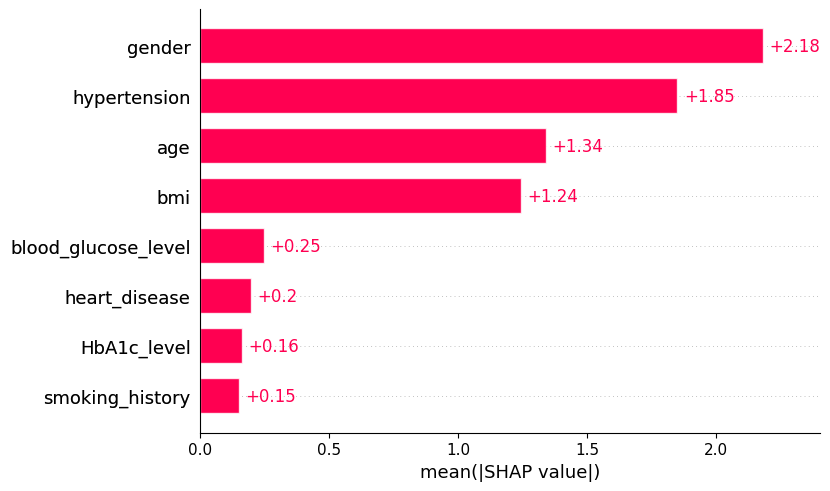

In [19]:
# Global bar plot

shap.plots.bar(shap_values)

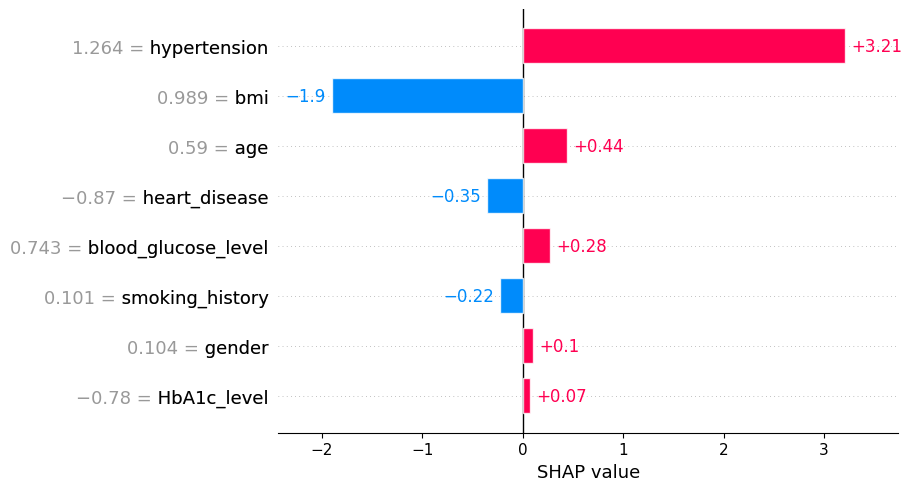

In [20]:
shap.plots.bar(shap_values[0])

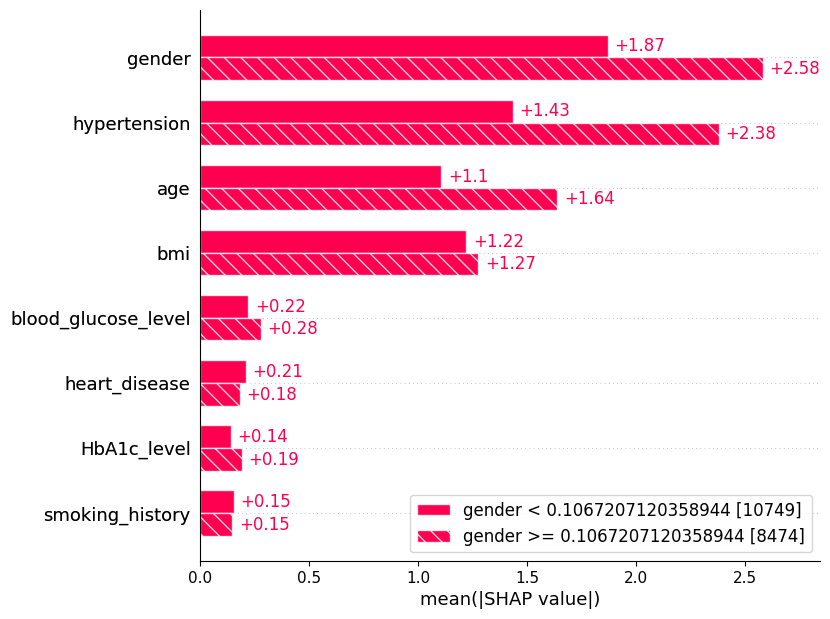

In [21]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

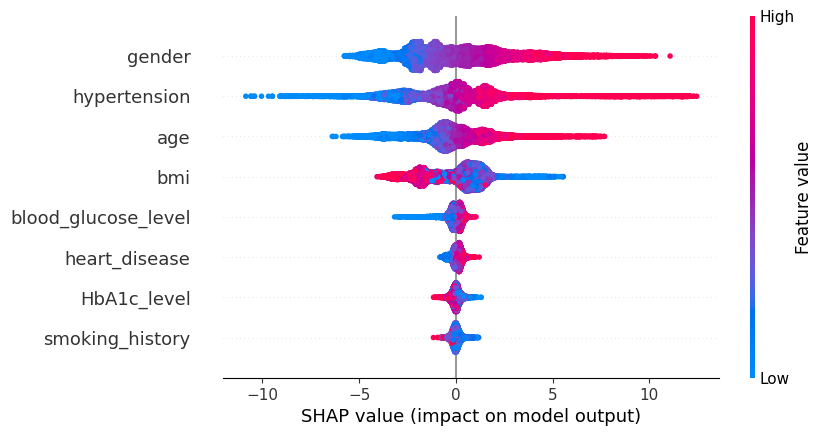

In [22]:
shap.plots.beeswarm(shap_values)

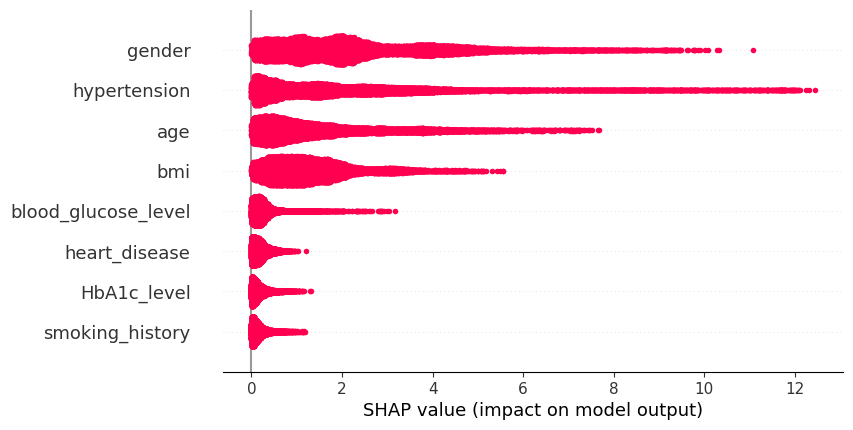

In [ ]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

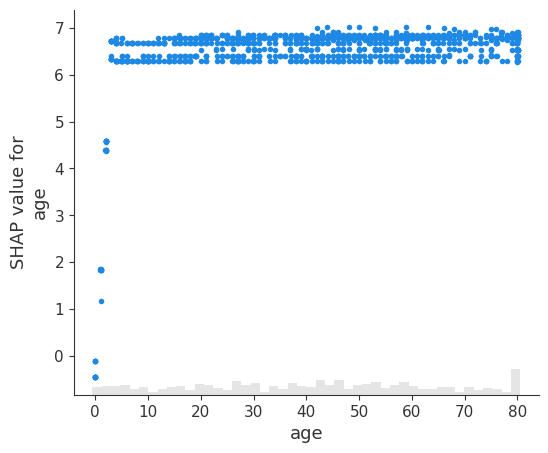

In [28]:
explanation = explainer(X[:1000])
shap.plots.scatter(explanation[:, "age"])

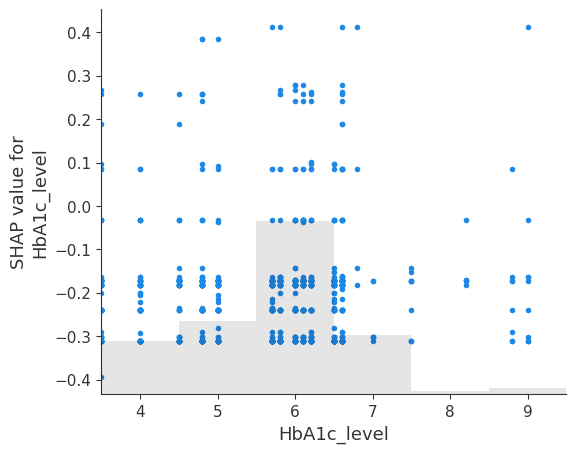

In [37]:
shap.plots.scatter(explanation[:, "HbA1c_level"])

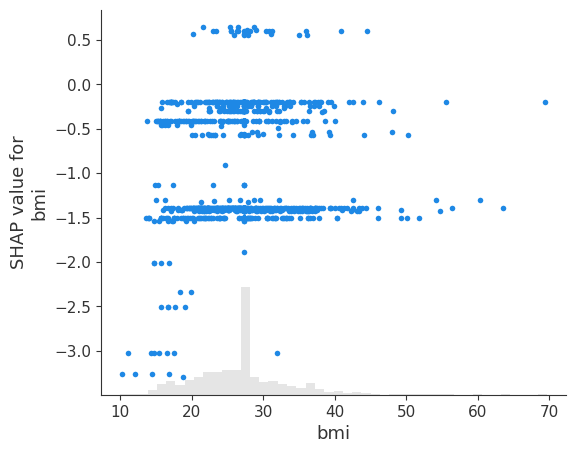

In [33]:
shap.plots.scatter(explanation[:, "bmi"])

In [ ]:
# Save feature names

feature_names = list(X.columns)
joblib.dump(feature_names, "../model/feature_names.pkl")

In [ ]:
# Save all components

joblib.dump(model, "../model/diabetes_model.pkl")
joblib.dump(scaler, "../model/scaler.pkl")
joblib.dump(pca, "../model/pca.pkl")
joblib.dump(le_gender, "../model/gender_encoder.pkl")
joblib.dump(le_smoking, "../model/smoking_encoder.pkl")